# Loan Default Prediction for Business Analysis using Machine Learning Algorithms

Created by Deep Borkar

### Project Overview

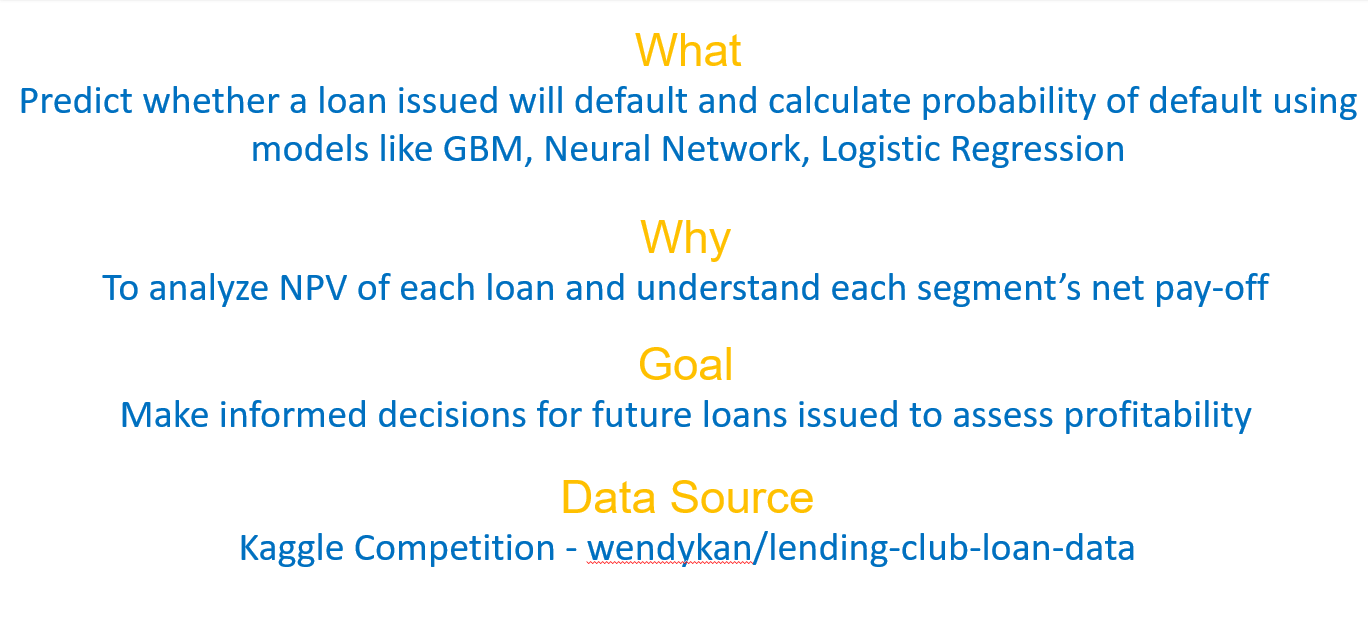

In [11]:
from IPython.display import Image, display
display(Image(filename='proj_ovw.png'))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

### Data Loading

Using the Pandas in-built function to read CSV files which is the format of the dataset. It can also be read using a SQL server. 

In [2]:
data = pd.read_csv('data/loan.csv')

This dataset comes with its data dictionary to describe the 145 variables. <br>I have created a function that will return the variable description. This is to help me during data analysis to understand the features better and relative to the target variable.

In [3]:
feature_desc = pd.read_csv('data/LCDataDictionary.csv', encoding = "ISO-8859-1")
feature_desc.index = feature_desc.LoanStatNew
feature_desc.drop(['LoanStatNew'], axis=1, inplace=True)

def define_var(var):
    print(var + ": " + feature_desc.loc[var][0])

In [4]:
df = data.copy()

### Data Summary

In [5]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, most of the variables are numerical and some of them are categorical which means they would need to be encoded accordingly.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [7]:
print("Missing Data: " + str(round(df.isnull().sum().sum() * 100/ (df.shape[0] * df.shape[1]), 2)) + "%. ", end='')
print(str(df.isnull().any().sum()) + " columns have missing data.")

Missing Data: 33.15%. 113 columns have missing data.


### Exploring the data

In [8]:
feature_desc.head()

,Description
LoanStatNew,
acc_now_delinq,The number of accounts on which the borrower i...
acc_open_past_24mths,Number of trades opened in past 24 months.
addr_state,The state provided by the borrower in the loan...
all_util,Balance to credit limit on all trades
annual_inc,The self-reported annual income provided by th...


After looking at all variables, this dataset is apt for a loan default prediction as it revolves around the loans made and has a variable called loan_status which describes the status of the payment.

In [9]:
define_var('loan_status')

loan_status: Current status of the loan


loan_status variable has 9 statuses for a particular loan. 

In [10]:
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

#### Setting Target variable

Here my goal is to map these 9 into 2 statuses that is No Default (0) or Default(1). <br>
To do this I consider the Status: 'Default', 'Charged Off' as Default and the rest as No Default.<br>
The reason for this is to create a distinction that categorizes Defaulted loans vs the active loans. This will help the purpose of the model.

In [11]:
loan_dict = {'Charged Off':1,
 'Current':0,
 'Default':1,
 'Does not meet the credit policy. Status:Charged Off':1,
 'Does not meet the credit policy. Status:Fully Paid':0,
 'Fully Paid':0,
 'In Grace Period':0,
 'Late (16-30 days)':0,
 'Late (31-120 days)':0}

df['loan_status'] = df.loan_status.map(loan_dict)

Throughout the data preprocessing, I would need to drop many columns, hence I have created a function to drop the column from the Data Frame and update it.

In [12]:
def drop_columns(df, cols):
    df.drop(cols, axis=1, inplace=True)
    print("Following columns have been dropped: ", cols)

These variables are post-default variables which means that these variables were recorded after the status was determined. <br>
This makes them highly correlated to the target variable which would affect our model.<br><br>
Also, these variables cannot be determined unless the status is known.

In [13]:
post_def_features = ['recoveries', 'collection_recovery_fee', 'debt_settlement_flag']

for var in post_def_features:
    define_var(var)

drop_columns(df, post_def_features)

recoveries: post charge off gross recovery
collection_recovery_fee: post charge off collection fee
debt_settlement_flag: Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.
Following columns have been dropped:  ['recoveries', 'collection_recovery_fee', 'debt_settlement_flag']


### Data Cleaning

Imputing variables with a lot of missing data would skew and generalize them. <br> As a threshold, I have selected 20% as the maximum missing values allowed.

In [14]:
missing_data_pct = df.isnull().sum() / df.shape[0]

drop_columns(df,missing_data_pct[missing_data_pct > 0.2].index)

Following columns have been dropped:  Index(['id', 'member_id', 'url', 'desc', 'mths_since_last_delinq',
       'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'revol_bal_joint',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 

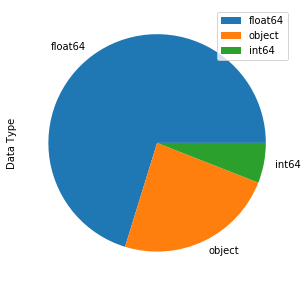

In [15]:
data_type = pd.DataFrame(df.dtypes.value_counts(), columns=['Data Type'])
plot = data_type.plot.pie(y='Data Type', figsize=(5,5))

To simplify and keep track of the variables, I have split the Data frame into two parts - Numerical variables and Categorical variables. <br><br>
This helps to encode and transform categorical variables separately and add them to the numerical data frame once they are translated to numerical. 

In [173]:
cat_cols = df[df.dtypes[df.dtypes==object].index]
num_cols = df[df.dtypes[df.dtypes!=object].index]

In [174]:
cat_cols.columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d',
       'application_type', 'hardship_flag', 'disbursement_method'],
      dtype='object')

Removing redundant columns.

In [175]:
drop_columns(cat_cols, ['emp_title', 'title', 'zip_code', 'addr_state', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'sub_grade'])

Following columns have been dropped:  ['emp_title', 'title', 'zip_code', 'addr_state', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'sub_grade']


### Feature Engineering

In [176]:
define_var('emp_length')

emp_len_dict = {'1 year': 1, '10+ years': 10, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,  '8 years': 8, '9 years': 9, '< 1 year':0}

num_cols['emp_length'] = cat_cols.emp_length.map(emp_len_dict)

cat_cols.drop(['emp_length'], axis=1, inplace=True)

emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


I have created a new feature here which converts the earliest credit line year to number of years till 2019.

In [177]:
num_cols['years_since_credit_line'] = 2019 - pd.to_datetime(cat_cols['earliest_cr_line']).dt.year
cat_cols.drop(['earliest_cr_line'], axis=1, inplace=True)

Cardinality helps to understand what kind of encoding is required for that variable.<br><br>
In the case of variables with cardinality 2 or 3, they can be label encoded. 
<br><br>
The variable grade is an ordinal variable and would require One Hot encoding or mapping.


### Data Transformation

In [178]:
cardinality = cat_cols.apply(pd.Series.nunique)
cardinality

term                    2
grade                   7
home_ownership          6
verification_status     3
pymnt_plan              2
purpose                14
initial_list_status     2
application_type        2
hardship_flag           2
disbursement_method     2
dtype: int64

In [179]:
cat_cols.shape

(2260668, 10)

In [180]:
def label_encoder(df, cols):
    from sklearn import preprocessing
    for col in tqdm(cols):
        le = preprocessing.LabelEncoder()
        df[col] = le.fit_transform(df[col])
    print("Label Encoding Done: ", cols)

In [181]:
label_encoder(cat_cols, cardinality[cardinality <= 3].index)


Label Encoding Done:  Index(['term', 'verification_status', 'pymnt_plan', 'initial_list_status',
       'application_type', 'hardship_flag', 'disbursement_method'],
      dtype='object')


In [182]:
cat_cols = pd.get_dummies(cat_cols, drop_first = True)

In [183]:
(cat_cols.dtypes == object).any()

False

In [184]:
cat_cols.isnull().any().any()

False

In [185]:
num_cols = pd.concat([num_cols, cat_cols], axis=1)

The following variables are redundant as they contain the copy of another variable.

In [186]:
drop_columns(num_cols,['funded_amnt', 'out_prncp_inv', 'funded_amnt_inv','total_pymnt_inv', 'last_pymnt_amnt', 'total_rec_prncp', 'total_rec_int'])

Following columns have been dropped:  ['funded_amnt', 'out_prncp_inv', 'funded_amnt_inv', 'total_pymnt_inv', 'last_pymnt_amnt', 'total_rec_prncp', 'total_rec_int']


### Missing Value Imputation

In [187]:
missing_cols = num_cols.isnull().sum()
missing_cols = missing_cols[missing_cols > 0]
missing_cols.index

Index(['annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'emp_length', 'years_si

Imputing continuous values which are missing not at random with either mean or median.

In [188]:
mean_impute = ['bc_util',  'pct_tl_nvr_dlq', 'dti', 'bc_open_to_buy', 'percent_bc_gt_75', 'revol_util', 'tax_liens']
med_impute = ['annual_inc']

In [189]:
def impute_missing_cols(df, cols, stgy):
    
    if stgy == 'mean':
       for col in cols:
            df[col].fillna(df[col].mean(), inplace=True)
    elif stgy == 'median':
        for col in cols:
            df[col].fillna(df[col].median(), inplace=True)
    else:
        print("Invalid.")

In [190]:
impute_missing_cols(num_cols, mean_impute, 'mean')
impute_missing_cols(num_cols, med_impute, 'median')

Imputing rest of the variables by a flag to penalize the missing values. A large negative flag here makes sense as most of the variables have a positive direction.

In [191]:
num_cols.fillna(-10000000,inplace=True)

In [192]:
num_cols.isnull().any().any()

False

### Feature Selection

Training on all 145 features would slow down the model and over power it as well. To make it efficient, I have used Random Forest as it uses GINI impurity to split and rank features according to their importance.

In [193]:
Y = num_cols['loan_status']
X = num_cols.drop('loan_status',1)

In [194]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
model.fit(X,Y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

Here I have selected the top 15 features for the model.

In [216]:
selected_cols = feat_importances.sort_values(ascending=False)[:15].index
X = X[selected_cols]

In [218]:
dec18_ind = df['issue_d'][df['issue_d'] == 'Dec-2018'].index

Here I have divided the model ready data where I have considered loans made in December 2018 which are the latest as New customers. <br><br> This way we can test our data on a new test set and also perform business analysis.

In [247]:
existing = pd.concat([num_cols[selected_cols].drop(dec18_ind, axis=0), num_cols['loan_status'].drop(dec18_ind, axis=0)], axis=1)
new = pd.concat([num_cols[selected_cols].iloc[dec18_ind],  num_cols['loan_status'].iloc[dec18_ind]], axis=1)

In [248]:
with open('data/selected_cols_15.data', 'wb') as filehandle:
        pickle.dump(selected_cols, filehandle)

In [250]:
existing.shape, new.shape

((2220534, 16), (40134, 16))

In [251]:
existing.to_csv('data/existing_customers.csv')
new.to_csv('data/new_customers.csv')